# Unit 5 - Financial Planning


In [183]:
# Initial imports
import os
import datetime
import json
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [184]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [185]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [186]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [187]:
# Fetch current BTC price
btc_price_response = requests.get(btc_url).json()
#btc_price_data.content
#print(json.dumps(btc_price_response,indent=2))
btc_price_usd = btc_price_response["data"]["1"]["quotes"]["USD"]["price"]
#print(type(btc_price_usd))

# Fetch current ETH price
eth_price_response = requests.get(eth_url).json()
#print(json.dumps(eth_price_response,indent=2))
eth_price_usd = eth_price_response["data"]["1027"]["quotes"]["USD"]["price"]

# Compute current value of my crpto
my_btc_value = my_btc * btc_price_usd
my_eth_value = my_eth * eth_price_usd

# Print current crypto wallet balance
print(f"Current value of your {my_btc} BTC is USD ${my_btc_value:0.2f}")
print(f"Current value of your {my_eth} ETH is USD ${my_eth_value:0.2f}")

Current value of your 1.2 BTC is USD $13611.01
Current value of your 5.3 ETH is USD $1950.61


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [188]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [189]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
#print(f"Alpaca Key type: {type(alpaca_api_key)}")
#print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
            alpaca_api_key,
            alpaca_secret_key,
            api_version="v2")

In [190]:
# Format current date as ISO format
#today = pd.Timestamp.today(tz="America/New_York").isoformat()
today = pd.Timestamp("2020-10-16",tz="America/New_York").isoformat()

# Set tickers, and '1D' timeframe for Alpaca API
tickers = ["AGG", "SPY"]
timeframe = "1D"

# Get current closing prices for SPY and AGG
portfolio_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
portfolio_df

AGG                                        SPY  \
                             open      high     low   close   volume    open   
time                                                                           
2020-10-16 00:00:00-04:00  117.99  118.0778  117.88  117.88  3591541  348.96   

                                                            
                             high    low   close    volume  
time                                                        
2020-10-16 00:00:00-04:00  350.75  347.1  347.25  62796942

In [191]:
# Pick AGG and SPY close prices
agg_close_price = float(portfolio_df["AGG"]["close"])
spy_close_price = float(portfolio_df["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Latest AGG closing price: ${agg_close_price}")
print(f"Latest SPY closing price: ${spy_close_price}")

Latest AGG closing price: $117.88
Latest SPY closing price: $347.25


In [192]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"Current market value of your {my_spy} SPY shares is USD ${my_spy_value:0.2f}")
print(f"Current market value of your {my_agg} AGG shares is USD ${my_agg_value:0.2f}")

Current market value of your 50 SPY shares is USD $17362.50
Current market value of your 200 AGG shares is USD $23576.00


### Savings Health Analysis

In [193]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
amounts = {"amount" : [(my_btc_value+my_eth_value),(my_spy_value+my_agg_value)]}
df_savings = pd.DataFrame(amounts,index=["crypto","shares"],columns=["amount"])

# Display savings DataFrame
display(df_savings)

,amount
crypto,15561.624
shares,40938.500


<AxesSubplot:ylabel='amount'>

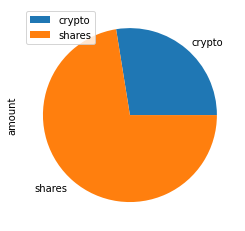

In [194]:
# Plot savings pie chart
df_savings.plot.pie(y="amount")


In [195]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings_total = float(df_savings.sum(axis=0))

# Validate saving health
if (savings_total > emergency_fund):
    print(f"Congratulations your savings are ${(savings_total - emergency_fund):0.2f} greater than emergency funds needed!")
elif savings_total==emergency_fund:
    print(f"Congratulations on saving ${(savings_total):0.2f} to fulfill an emergency fund! Keep on saving!")
else:
    print(f"Your savings are ${(emergency_fund - savings_total):0.2f} shy of filling an emergency fund. Keep saving to reach this goal.")

Congratulations your savings are $20500.12 greater than emergency funds needed!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [196]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp("2015-10-16",tz="America/New_York").isoformat()
end_date = today


In [197]:
# Get 5 years' worth of historical data for SPY and AGG

df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
df_stock_data.head()

AGG                                       SPY  \
                             open     high     low   close   volume    open   
time                                                                          
2015-10-16 00:00:00-04:00  109.90  109.940  109.78  109.78  1497588  202.83   
2015-10-19 00:00:00-04:00  109.78  109.895  109.65  109.85  1289942  202.50   
2015-10-20 00:00:00-04:00  109.64  109.780  109.55  109.65  1672562  202.85   
2015-10-21 00:00:00-04:00  109.73  109.950  109.73  109.89  1119723  203.61   
2015-10-22 00:00:00-04:00  109.90  110.050  109.83  109.94  1817244  202.98   

                                                                
                             high       low   close     volume  
time                                                            
2015-10-16 00:00:00-04:00  203.29  201.9200  203.14   79323870  
2015-10-19 00:00:00-04:00  203.37  202.1300  203.33   61255929  
2015-10-20 00:00:00-04:00  203.84  202.5471  203.07   60081395  
2015-10-21 00:00:00-04:00  203.79  201.6500  201.82   83704739  
2015-10-22 00:00:00-04:00  205.51  202.8100  205.22  121670959

In [198]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# Initial run using 60% weight for stocks, 40% weight for bonds
num_sim_yrs = 30
MC_6040_dist = MCSimulation(
                portfolio_data = df_stock_data,
                weights = [0.4,0.6],
                num_simulation=500,
                num_trading_days=(252*num_sim_yrs))


In [199]:
# Printing the simulation input data
MC_6040_dist.portfolio_data.head()

AGG                                    \
                             open     high     low   close   volume   
time                                                                  
2015-10-16 00:00:00-04:00  109.90  109.940  109.78  109.78  1497588   
2015-10-19 00:00:00-04:00  109.78  109.895  109.65  109.85  1289942   
2015-10-20 00:00:00-04:00  109.64  109.780  109.55  109.65  1672562   
2015-10-21 00:00:00-04:00  109.73  109.950  109.73  109.89  1119723   
2015-10-22 00:00:00-04:00  109.90  110.050  109.83  109.94  1817244   

                                           SPY                            \
                          daily_return    open    high       low   close   
time                                                                       
2015-10-16 00:00:00-04:00          NaN  202.83  203.29  201.9200  203.14   
2015-10-19 00:00:00-04:00     0.000638  202.50  203.37  202.1300  203.33   
2015-10-20 00:00:00-04:00    -0.001821  202.85  203.84  202.5471  203.07   
2015-10-21 00:00:00-04:00     0.002189  203.61  203.79  201.6500  201.82   
2015-10-22 00:00:00-04:00     0.000455  202.98  205.51  202.8100  205.22   

                                                   
                              volume daily_return  
time                                               
2015-10-16 00:00:00-04:00   79323870          NaN  
2015-10-19 00:00:00-04:00   61255929     0.000935  
2015-10-20 00:00:00-04:00   60081395    -0.001279  
2015-10-21 00:00:00-04:00   83704739    -0.006156  
2015-10-22 00:00:00-04:00  121670959     0.016847

In [200]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_6040_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011255,1.010338,1.009490,0.985779,1.001129,1.011821,1.001270,0.994143,1.021589,1.002924,...,1.011563,1.005225,0.997930,1.002328,0.994933,0.982648,1.000944,1.008771,0.998612,1.000728
2,1.016233,1.006058,1.014154,0.980571,1.002511,1.015916,1.011863,0.971650,1.025127,0.993224,...,1.017327,1.008726,1.002895,1.004391,0.995637,0.980788,1.004543,1.020778,0.998646,0.995780
3,1.011734,1.005349,1.003938,0.980073,0.998997,1.016741,1.018970,0.969009,1.017942,0.991112,...,1.017346,1.009272,1.006763,1.003570,0.989870,0.982130,1.000465,1.004035,1.009475,0.986502
4,1.016962,1.002428,1.011813,0.973619,0.997613,1.004005,1.011035,0.970778,1.019351,0.990148,...,1.022355,1.005842,1.009651,1.004558,0.989254,0.988975,0.992686,1.003635,1.007469,0.989503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.058497,5.378148,7.447233,8.693582,16.830390,9.249691,22.531483,7.897532,29.747899,6.261169,...,11.214811,5.845786,15.415860,9.029201,6.480365,12.913272,10.635930,13.834556,10.833772,16.973716
7557,6.086719,5.327146,7.406689,8.641844,16.581143,9.214479,22.509269,7.954628,29.501729,6.191380,...,11.199716,5.779036,15.339658,9.115488,6.488865,12.745915,10.692125,13.708212,10.923234,17.118089
7558,6.102997,5.267435,7.432463,8.687856,16.429460,9.191307,22.871196,7.972181,29.393083,6.244211,...,11.245275,5.872905,15.389569,9.207793,6.472435,12.839542,10.743690,13.472768,10.962946,17.355818
7559,6.174188,5.224464,7.481006,8.794836,16.458526,9.200174,22.976192,7.999341,29.396619,6.150240,...,11.180610,5.828792,15.367495,9.232779,6.413569,12.845382,10.821781,13.513708,11.045547,17.207370


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

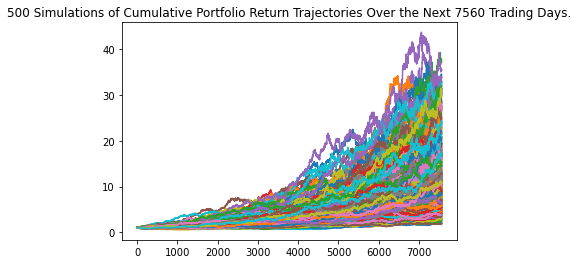

In [201]:
# Plot simulation outcomes
MC_6040_dist.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

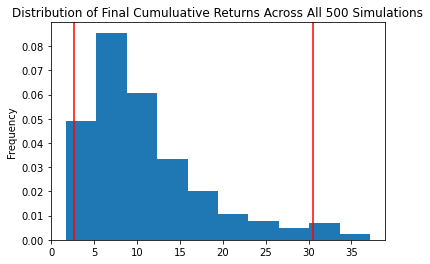

In [202]:
# Plot probability distribution and confidence intervals
MC_6040_dist.plot_distribution()

### Retirement Analysis

In [203]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_list_6040_dist = MC_6040_dist.summarize_cumulative_return()

# Print summary statistics
print(summary_list_6040_dist)

count           500.000000
mean             10.956316
std               6.942894
min               1.681710
25%               5.948212
50%               8.960916
75%              13.525546
max              37.193583
95% CI Lower      2.665679
95% CI Upper     30.484601
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [204]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_list_6040_dist[8]*initial_investment,2)
ci_upper = round(summary_list_6040_dist[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio over the next 30 years\n"
      f"will end within in the range of ${ci_lower:0.2f} and ${ci_upper:0.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years
will end within in the range of $53313.58 and $609692.02


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [205]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_list_6040_dist[8]*initial_investment,2)
ci_upper = round(summary_list_6040_dist[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:0.0f} in the portfolio over the next 30 years\n"
      f"will end within in the range of ${ci_lower:0.2f} and ${ci_upper:0.2f}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years
will end within in the range of $79970.37 and $914538.02


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [206]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# More aggressive distribution of 80% weight for stocks, 20% weight for bonds
num_sim_yrs = 5
MC_8020_dist = MCSimulation(
                portfolio_data = df_stock_data,
                weights = [0.2,0.8],
                num_simulation=500,
                num_trading_days=(252*num_sim_yrs))


In [207]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_8020_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996553,0.994458,1.001385,0.999655,1.008993,1.004121,1.012542,0.997427,1.003356,0.997519,...,1.004229,1.016019,0.996307,0.998817,0.990632,0.981958,1.003376,0.992851,1.008719,0.988332
2,0.980171,0.997938,1.011821,1.021453,1.008618,1.001260,0.999902,0.997461,1.005531,1.001351,...,0.993728,1.008453,1.002648,1.001896,1.003801,0.970179,1.015327,1.002330,1.003310,0.979962
3,0.982580,1.005283,1.019656,1.020415,0.982664,0.993307,1.013292,1.008100,1.021731,0.994459,...,0.987471,1.012209,1.013214,1.006415,0.996360,0.955333,1.003892,1.004592,0.997269,0.987325
4,0.994216,1.011493,1.022979,1.024603,0.992826,0.974639,1.026286,0.991899,1.009216,0.987689,...,0.968831,1.019435,1.012699,1.008302,0.983424,0.956578,1.005386,1.020279,0.998260,0.990903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.471855,1.690186,2.199186,1.967406,1.704409,1.835914,3.267107,2.193265,2.629988,1.955138,...,1.343054,1.978578,1.604209,1.420205,1.667257,0.907009,1.494727,1.469619,2.412023,1.000019
1257,1.479470,1.683810,2.207148,1.997516,1.761218,1.832881,3.231064,2.211801,2.608487,1.974564,...,1.350657,1.969891,1.581235,1.431376,1.681645,0.908064,1.491840,1.488159,2.446974,0.993679
1258,1.480069,1.678476,2.224307,1.990232,1.729617,1.831623,3.230685,2.183534,2.639124,1.998460,...,1.360511,1.983335,1.592485,1.423675,1.696553,0.903301,1.481646,1.496081,2.433878,0.995439
1259,1.484361,1.670011,2.180605,2.012197,1.750475,1.827658,3.192317,2.181805,2.639087,1.965570,...,1.379872,1.935991,1.582061,1.417517,1.693941,0.896168,1.485113,1.474418,2.450808,1.000906


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

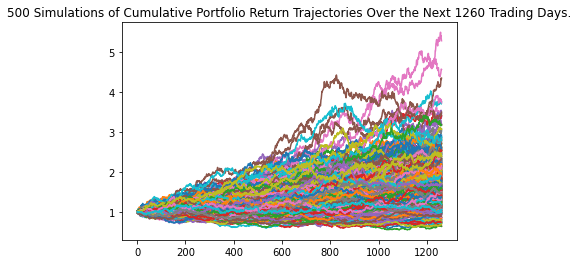

In [208]:
# Plot simulation outcomes
MC_8020_dist.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

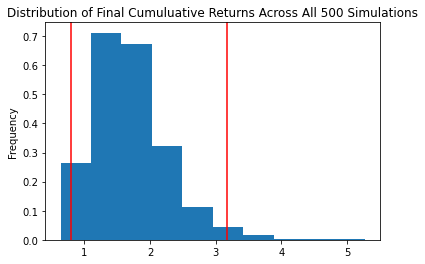

In [209]:
# Plot probability distribution and confidence intervals
MC_8020_dist.plot_distribution()

In [210]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_list_8020_dist = MC_8020_dist.summarize_cumulative_return()

# Print summary statistics
print(summary_list_8020_dist)

count           500.000000
mean              1.703341
std               0.595806
min               0.637340
25%               1.292533
50%               1.614143
75%               1.992578
max               5.273253
95% CI Lower      0.795253
95% CI Upper      3.167819
Name: 1260, dtype: float64


In [211]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower = round(summary_list_8020_dist[8]*initial_investment,2)
ci_upper = round(summary_list_8020_dist[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio over the next 5 years\n"
      f"will end within in the range of ${ci_lower:0.2f} and ${ci_upper:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years
will end within in the range of $47715.18 and $190069.12


### Ten Years Retirement Option

In [212]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# More aggressive distribution of 80% weight for stocks, 20% weight for bonds
num_sim_yrs = 10
MC_8020_dist = MCSimulation(
                portfolio_data = df_stock_data,
                weights = [0.2,0.8],
                num_simulation=500,
                num_trading_days=(252*num_sim_yrs))


In [213]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_8020_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991367,1.005323,1.003178,1.001999,1.003848,1.012967,1.013699,0.993374,1.010618,1.011990,...,0.990223,0.991388,1.005410,1.014287,0.998727,1.025402,0.978613,1.020681,0.999867,0.992894
2,1.000645,1.020955,1.003319,0.987233,1.014651,1.008393,1.005553,1.011332,1.016446,1.010765,...,0.989152,1.008932,1.000788,1.020757,0.991534,1.044272,0.981169,1.023312,0.990442,0.992174
3,0.999228,1.021524,1.000497,1.003662,1.005572,1.006698,0.989301,1.008353,1.018934,1.038037,...,1.004504,1.018243,0.990957,1.020022,0.995642,1.043352,0.962082,1.013906,0.979130,0.991503
4,0.998895,1.012285,1.006851,1.005911,1.022548,1.009226,0.990797,1.005173,1.022399,1.049928,...,1.008570,1.035465,0.994024,1.036271,0.994348,1.036612,0.970425,0.993406,0.991206,0.989847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.203196,2.374952,3.714073,3.163699,3.004620,3.617978,1.932577,1.204505,5.792660,2.123453,...,2.531684,1.950942,1.121807,3.040734,2.474876,1.633988,2.947562,2.628305,2.258976,1.539495
2517,2.162190,2.355309,3.721113,3.191324,3.016608,3.715207,1.919148,1.208817,5.742381,2.129728,...,2.533930,1.957864,1.127843,3.042572,2.448209,1.638162,2.915346,2.636288,2.234246,1.512952
2518,2.181665,2.342321,3.719532,3.179687,2.980485,3.716874,1.933169,1.209496,5.846747,2.119577,...,2.555394,1.926915,1.101759,3.049334,2.450780,1.628400,2.925610,2.635125,2.205897,1.516927
2519,2.198721,2.307197,3.725533,3.172253,2.989371,3.646371,1.936778,1.207279,5.842011,2.106372,...,2.532457,1.926345,1.105381,3.050904,2.453576,1.644800,2.918637,2.674766,2.247208,1.512489


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

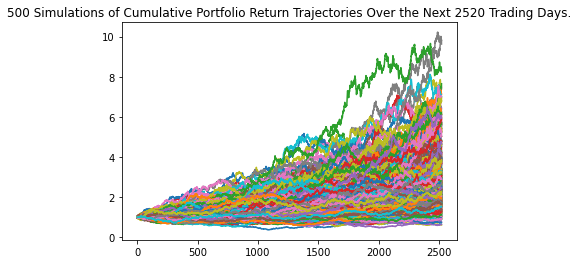

In [214]:
# Plot simulation outcomes
MC_8020_dist.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

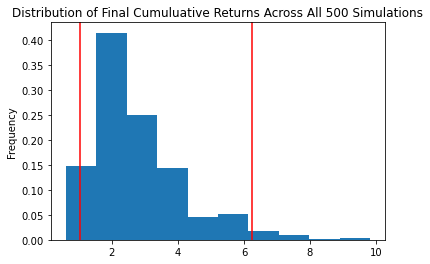

In [215]:
# Plot probability distribution and confidence intervals
MC_8020_dist.plot_distribution()

In [216]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_list_8020_dist = MC_8020_dist.summarize_cumulative_return()

# Print summary statistics
print(summary_list_8020_dist)

count           500.000000
mean              2.777935
std               1.413734
min               0.603273
25%               1.779102
50%               2.395461
75%               3.374536
max               9.819999
95% CI Lower      1.037909
95% CI Upper      6.239188
Name: 2520, dtype: float64


In [217]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower = round(summary_list_8020_dist[8]*initial_investment,2)
ci_upper = round(summary_list_8020_dist[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio over the next 10 years\n"
      f"will end within in the range of ${ci_lower:0.2f} and ${ci_upper:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years
will end within in the range of $62274.53 and $374351.28
